<h1>SECTION 1- EDA

In [1]:

import os
import pickle
import numpy as np
import pandas as pd
import neurokit2 as nk #Special library for bio-signal processing (Pip install this before running the notebook)

# Point to one subject .pkl
base_dir = "C:\FILE IQBAL\KULIAH_MDSI\MDSI\SEMESTER 4\CAPSTONE PROJECT\Modelling Stage\CAPSTONE-MODEL\data\WESAD" ## replace this directory to your base directory for WESAD Folder
subject_id = "S2"
pkl_path = os.path.join(base_dir, subject_id, f"{subject_id}.pkl")

LABEL_MAP = {
    0: "Undefined/Transition",
    1: "Baseline",
    2: "Stress",
    3: "Amusement",
    4: "Meditation",
    5: "ignored_1",
    6: "ignored_2",
    7: "ignored_3"
}


In [2]:
def load_wesad_subject(pkl_path: str):
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')  # WESAD is py2-pickled
    return data

def safe_get_signal(sig_entry):
    """Return np.ndarray regardless of dict/wrapper structure."""
    if isinstance(sig_entry, dict) and "signal" in sig_entry:
        return np.asarray(sig_entry["signal"])
    return np.asarray(sig_entry)


data = load_wesad_subject(pkl_path)
print("Top-level keys:", list(data.keys()))
print("Devices:", list(data["signal"].keys()))
print("Label shape:", np.asarray(data["label"]).shape)


Top-level keys: ['signal', 'label', 'subject']
Devices: ['chest', 'wrist']
Label shape: (4255300,)


In [3]:
def to_series(arr, fs, name):
    t = pd.to_timedelta(np.arange(len(arr)) / fs, unit="s")
    s = pd.Series(np.asarray(arr).squeeze(), index=t, name=name)
    s.index.name = "time"
    return s

eda_entry = data["signal"]["wrist"]["EDA"]
eda_signal = safe_get_signal(eda_entry)
eda_fs = eda_entry["sampling_rate"] if isinstance(eda_entry, dict) else 4
test_eda = to_series(eda_signal, eda_fs, "W_EDA")
print(test_eda.head())


time
0 days 00:00:00           1.138257
0 days 00:00:00.250000    1.125444
0 days 00:00:00.500000    1.011405
0 days 00:00:00.750000    1.033188
0 days 00:00:01           0.935807
Name: W_EDA, dtype: float64


In [4]:
def extract_wrist_df(data) -> pd.DataFrame:
    e4 = data["signal"]["wrist"]
    parts = []
    if "EDA" in e4:
        arr = safe_get_signal(e4["EDA"])
        fs = e4["EDA"]["sampling_rate"] if isinstance(e4["EDA"], dict) else 4
        parts.append(to_series(arr, fs, "W_EDA"))
    if "TEMP" in e4:
        arr = safe_get_signal(e4["TEMP"])
        fs = e4["TEMP"]["sampling_rate"] if isinstance(e4["TEMP"], dict) else 4
        parts.append(to_series(arr, fs, "W_TEMP"))
    if "BVP" in e4:
        arr = safe_get_signal(e4["BVP"])
        fs = e4["BVP"]["sampling_rate"] if isinstance(e4["BVP"], dict) else 64
        parts.append(to_series(arr, fs, "W_BVP"))
    if "ACC" in e4:
        arr = safe_get_signal(e4["ACC"])
        fs = e4["ACC"]["sampling_rate"] if isinstance(e4["ACC"], dict) else 32
        for i, ax in enumerate(["X","Y","Z"]):
            parts.append(to_series(arr[:, i], fs, f"W_ACC_{ax}"))
    return pd.concat(parts, axis=1).sort_index()

wrist_df = extract_wrist_df(data)
print("Wrist columns:", list(wrist_df.columns))
display(wrist_df.head())
print("Wrist data shape:", wrist_df.shape)

Wrist columns: ['W_EDA', 'W_TEMP', 'W_BVP', 'W_ACC_X', 'W_ACC_Y', 'W_ACC_Z']


,W_EDA,W_TEMP,W_BVP,W_ACC_X,W_ACC_Y,W_ACC_Z
time,,,,,,
0 days 00:00:00,1.138257,35.41,-59.37,62.0,-21.0,107.0
0 days 00:00:00.015625,NaN,NaN,-53.42,NaN,NaN,NaN
0 days 00:00:00.031250,NaN,NaN,-44.40,66.0,13.0,53.0
0 days 00:00:00.046875,NaN,NaN,-33.17,NaN,NaN,NaN
0 days 00:00:00.062500,NaN,NaN,-20.79,41.0,9.0,15.0


Wrist data shape: (389056, 6)


In [20]:
def extract_chest_df(data) -> pd.DataFrame:
    ch = data["signal"]["chest"]
    # Helpful to see what's actually present in this subject:
    print("Chest keys present:", list(ch.keys()))
    parts = []

    def _fs(entry, default=700):
        return entry["sampling_rate"] if isinstance(entry, dict) and "sampling_rate" in entry else default

    def _sig(entry):
        return safe_get_signal(entry)

    # Respiration
    if "Resp" in ch:
        arr = _sig(ch["Resp"]); fs = _fs(ch["Resp"])
        parts.append(to_series(arr, fs, "C_RESP"))

    # ECG
    if "ECG" in ch:
        arr = _sig(ch["ECG"]); fs = _fs(ch["ECG"])
        parts.append(to_series(arr, fs, "C_ECG"))

    # EDA
    if "EDA" in ch:
        arr = _sig(ch["EDA"]); fs = _fs(ch["EDA"])
        parts.append(to_series(arr, fs, "C_EDA"))

    # EMG  <-- this was missing before
    if "EMG" in ch:
        arr = _sig(ch["EMG"]); fs = _fs(ch["EMG"])
        # EMG is typically single-channel
        parts.append(to_series(arr, fs, "C_EMG"))

    # Temperature
    if "Temp" in ch:
        arr = _sig(ch["Temp"]); fs = _fs(ch["Temp"])
        parts.append(to_series(arr, fs, "C_TEMP"))

    # 3-axis Accelerometer
    if "ACC" in ch:
        arr = _sig(ch["ACC"]); fs = _fs(ch["ACC"])
        # arr shape should be (N, 3); guard just in case
        arr = np.asarray(arr)
        if arr.ndim == 2 and arr.shape[1] >= 3:
            for i, ax in enumerate(["X","Y","Z"]):
                parts.append(to_series(arr[:, i], fs, f"C_ACC_{ax}"))
        else:
            # fallback: single column
            parts.append(to_series(arr.squeeze(), fs, "C_ACC"))

    if not parts:
        return pd.DataFrame()

    return pd.concat(parts, axis=1).sort_index()


chest_df = extract_chest_df(data)
print("Chest columns:", list(chest_df.columns))
display(chest_df.head())
print("Total chest columns:", chest_df.shape[1])

Chest keys present: ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
Chest columns: ['C_RESP', 'C_ECG', 'C_EDA', 'C_EMG', 'C_TEMP', 'C_ACC_X', 'C_ACC_Y', 'C_ACC_Z']


,C_RESP,C_ECG,C_EDA,C_EMG,C_TEMP,C_ACC_X,C_ACC_Y,C_ACC_Z
time,,,,,,,,
0 days 00:00:00,-1.148987,0.021423,5.250549,-0.004440,30.120758,0.9554,-0.2220,-0.5580
0 days 00:00:00.001428571,-1.124573,0.020325,5.267334,0.004349,30.129517,0.9258,-0.2216,-0.5538
0 days 00:00:00.002857143,-1.152039,0.016525,5.243301,0.005173,30.138214,0.9082,-0.2196,-0.5392
0 days 00:00:00.004285714,-1.158142,0.016708,5.249405,0.007187,30.129517,0.8974,-0.2102,-0.5122
0 days 00:00:00.005714286,-1.161194,0.011673,5.286407,-0.015152,30.130951,0.8882,-0.2036,-0.4824


Total chest columns: 8


In [21]:
def labels_series(data, fs_guess=700):
    y = np.asarray(data["label"]).squeeze()
    s = to_series(y, fs_guess, "label_raw")
    return s.astype(int)

y_series = labels_series(data, fs_guess=700)
print("Label counts:", y_series.value_counts().sort_index().to_dict())


Label counts: {0: 2142701, 1: 800800, 2: 430500, 3: 253400, 4: 537599, 6: 45500, 7: 44800}


In [22]:
def resample_df(df: pd.DataFrame, target_fs: float) -> pd.DataFrame:
    """Resample each column to target_fs using NeuroKit2's signal_resample.
       Keeps a TimedeltaIndex (elapsed time)."""
    if df.empty:
        return df
    # infer original fs from TimedeltaIndex
    dt = (df.index[1] - df.index[0]).total_seconds()
    orig_fs = 1.0 / dt
    target_length = int(np.round(len(df) * (target_fs / orig_fs)))
    out_cols = {}
    for col in df.columns:
        x = df[col].interpolate(limit_direction="both").to_numpy()
        y = nk.signal_resample(
            x,
            sampling_rate=orig_fs,
            desired_length=target_length,
            method="numpy"
        )
        out_cols[col] = y
    # TimedeltaIndex (elapsed time)
    t = pd.to_timedelta(np.arange(target_length) / target_fs, unit="s")
    return pd.DataFrame(out_cols, index=t).rename_axis("time")

def resample_series(s: pd.Series, target_fs: float) -> pd.Series:
    """Resample a series to target_fs; keeps TimedeltaIndex (elapsed time)."""
    if s.empty:
        return s
    dt = (s.index[1] - s.index[0]).total_seconds()
    orig_fs = 1.0 / dt
    target_length = int(np.round(len(s) * (target_fs / orig_fs)))
    x = s.interpolate(limit_direction="both").to_numpy()
    y = nk.signal_resample(
        x,
        sampling_rate=orig_fs,
        desired_length=target_length,
        method="numpy"
    )
    t = pd.to_timedelta(np.arange(target_length) / target_fs, unit="s")
    out = pd.Series(y, index=t, name=s.name)
    out.index.name = "time"
    return out


In [23]:
wrist_df_4hz = resample_df(wrist_df, target_fs=4.0)
labels_4hz   = resample_series(y_series, target_fs=4.0).round().astype(int)

print("Wrist @4Hz:", wrist_df_4hz.shape, "| Labels @4Hz:", labels_4hz.shape)
display(wrist_df_4hz.head(), labels_4hz.head())

Wrist @4Hz: (24316, 6) | Labels @4Hz: (24306,)


,W_EDA,W_TEMP,W_BVP,W_ACC_X,W_ACC_Y,W_ACC_Z
time,,,,,,
0 days 00:00:00,1.138257,35.41,-59.37,62.0,-21.0,107.0
0 days 00:00:00.250000,1.125444,35.41,43.50,51.0,16.0,35.0
0 days 00:00:00.500000,1.011405,35.41,53.56,53.0,21.0,-6.0
0 days 00:00:00.750000,1.033188,35.41,54.64,55.0,17.0,34.0
0 days 00:00:01,0.935807,35.41,-117.88,48.0,24.0,15.0


time
0 days 00:00:00           0
0 days 00:00:00.250000    0
0 days 00:00:00.500000    0
0 days 00:00:00.750000    0
0 days 00:00:01           0
Name: label_raw, dtype: int64

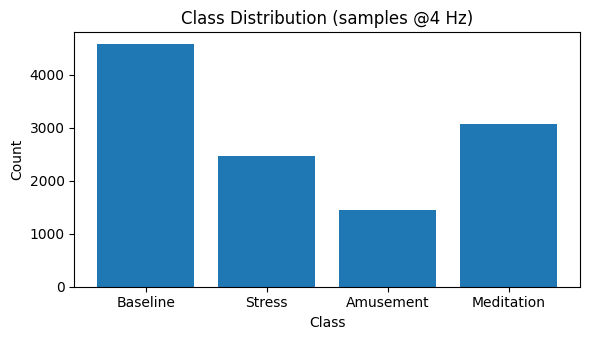

In [ ]:
import matplotlib.pyplot as plt

LABEL_MAP = {0:"Transition",1:"Baseline",2:"Stress",3:"Amusement",4:"Meditation"}

main_classes = [1,2,3,4] # There are more than 4 labels in the actual dataset.
counts = labels_4hz[labels_4hz.isin(main_classes)].value_counts().sort_index()

plt.figure(figsize=(6,3.5))
plt.bar([LABEL_MAP.get(i,str(i)) for i in counts.index], counts.values)
plt.title("Class Distribution (samples @4 Hz)")
plt.xlabel("Class"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

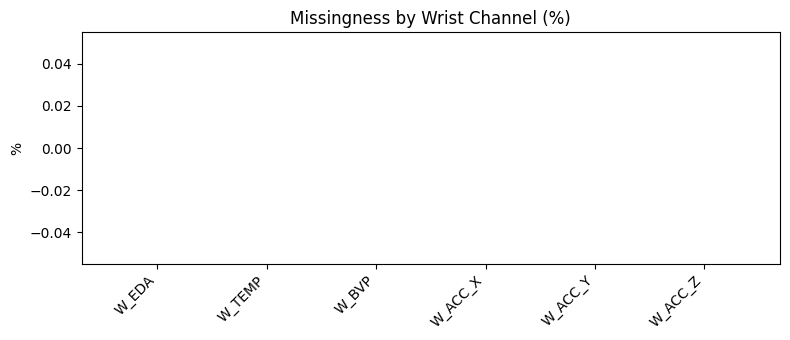

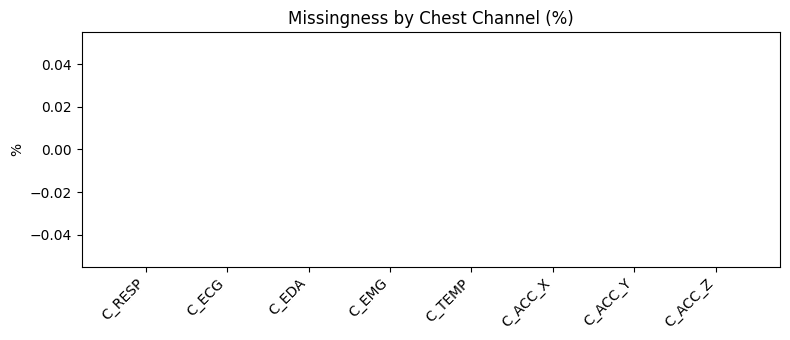

In [28]:
# Wrist channels (4 Hz resampled)
na_pct_wrist = wrist_df_4hz.isna().mean().sort_values(ascending=False)*100
plt.figure(figsize=(8,3.5))
plt.bar(na_pct_wrist.index, na_pct_wrist.values)
plt.xticks(rotation=45, ha='right')
plt.title("Missingness by Wrist Channel (%)"); plt.ylabel("%"); plt.tight_layout(); plt.show()

# Chest channels (native fs)
na_pct_chest = chest_df.isna().mean().sort_values(ascending=False)*100
plt.figure(figsize=(8,3.5))
plt.bar(na_pct_chest.index, na_pct_chest.values)
plt.xticks(rotation=45, ha='right')
plt.title("Missingness by Chest Channel (%)"); plt.ylabel("%"); plt.tight_layout(); plt.show()

##### We examined missingness across wrist and chest signals. All channels had 0% missing values after loading and resampling, indicating the dataset is complete for this subject. Therefore, no imputation was required at this stage.

#### Original WESAD .pkl signals often don’t contain NaNs — they are continuous recordings from sensors.

In [29]:
def describe_channels(df: pd.DataFrame, name=""):
    desc = df.describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).T
    desc = desc[["mean","std","min","5%","50%","95%","max"]]
    print(f"\nSummary stats ({name}):")
    display(desc)

describe_channels(wrist_df_4hz, "Wrist @4Hz")
describe_channels(chest_df, "Chest (native fs)")


Summary stats (Wrist @4Hz):


,mean,std,min,5%,50%,95%,max
W_EDA,0.391743,0.329236,0.045113,0.101492,0.236032,1.13047,1.717419
W_TEMP,34.386945,1.045340,32.310000,32.590000,34.250000,35.89000,35.970000
W_BVP,-0.288603,76.327816,-731.270000,-100.607500,3.055000,102.03750,618.940000
W_ACC_X,39.716277,19.485409,-85.000000,12.000000,44.000000,63.00000,127.000000
W_ACC_Y,-0.403027,33.214392,-109.000000,-59.000000,5.000000,50.00000,67.000000
W_ACC_Z,18.972323,25.011108,-128.000000,-30.000000,17.000000,60.00000,107.000000



Summary stats (Chest (native fs)):


,mean,std,min,5%,50%,95%,max
C_RESP,0.054906,2.917749,-27.903748,-3.802490,-0.157166,4.208374,27.378845
C_ECG,0.001212,0.154077,-1.499542,-0.197937,0.008240,0.229660,1.499313
C_EDA,1.528387,1.238425,0.263214,0.502396,1.163101,5.156326,7.576752
C_EMG,-0.002413,0.011652,-0.414963,-0.020920,-0.001602,0.014420,0.300980
C_TEMP,30.876677,1.281106,28.045258,28.373169,31.289917,32.229126,34.370392
C_ACC_X,0.753866,0.175116,0.215000,0.401800,0.856800,0.914400,2.029800
C_ACC_Y,-0.133188,0.064173,-0.660000,-0.251400,-0.125600,-0.056600,0.539000
C_ACC_Z,-0.422681,0.300236,-1.135400,-0.862600,-0.322200,0.065600,1.246800


#### Condition slices (2 min per label)

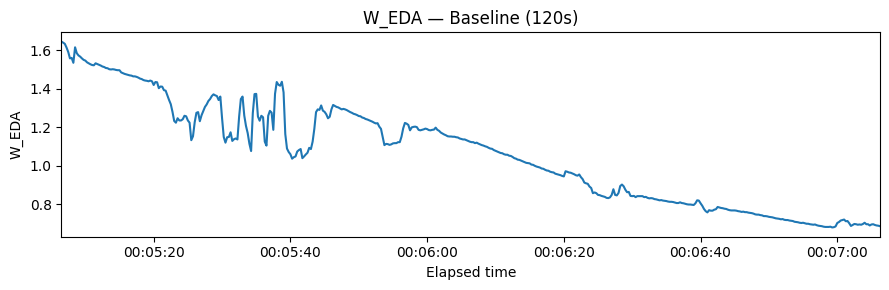

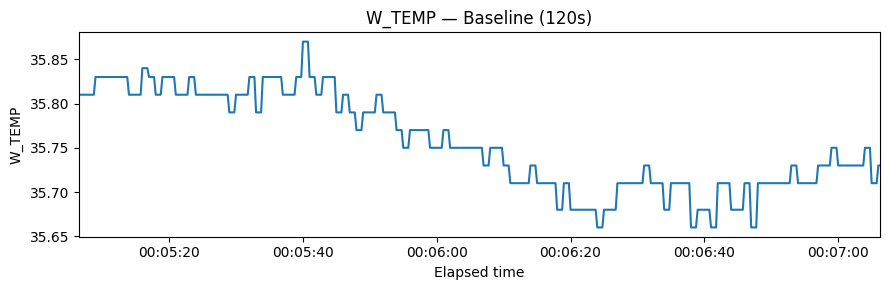

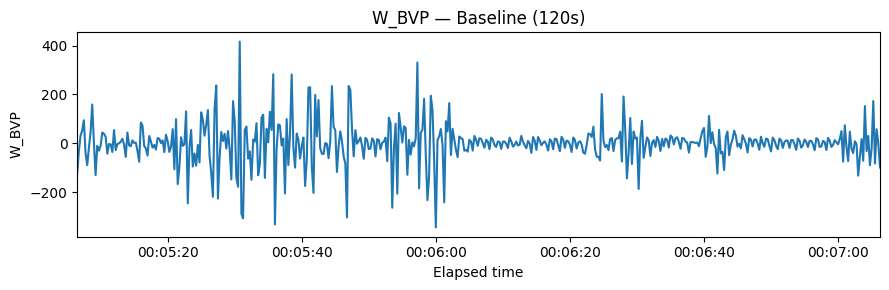

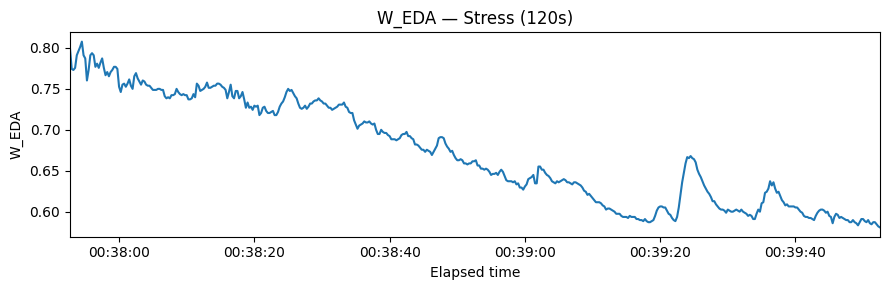

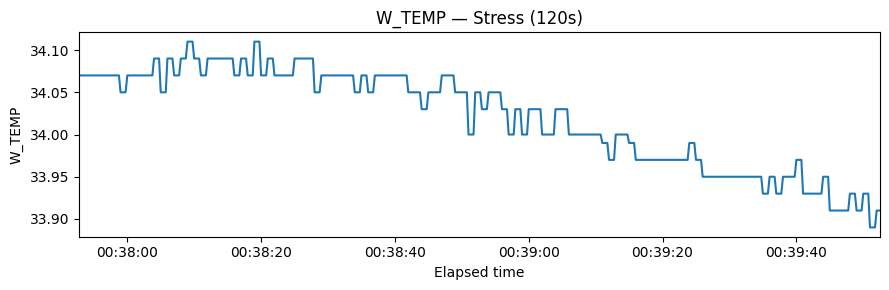

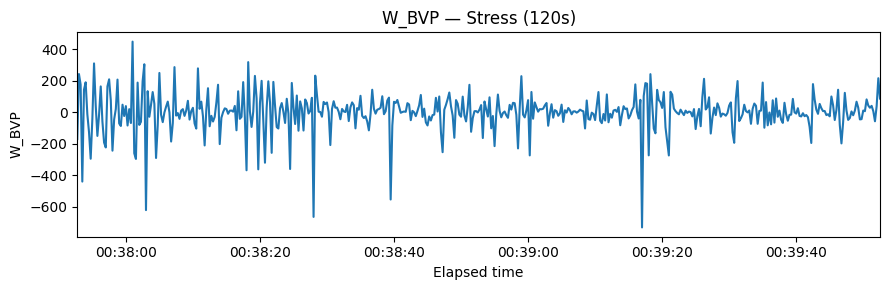

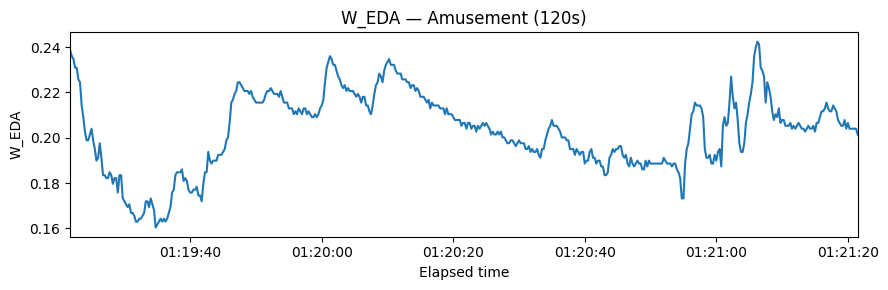

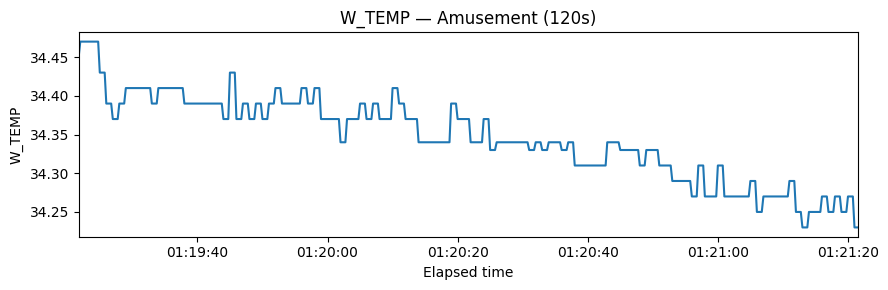

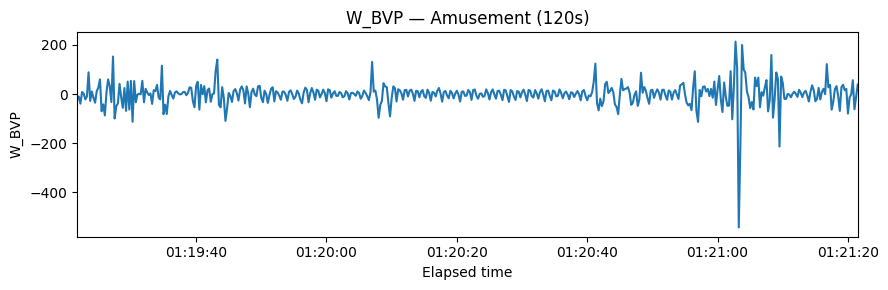

In [30]:
def pick_segment_by_label(labels_4hz, label_value, seconds=120):
    y = labels_4hz.dropna().astype(int)
    idx = y.index[y.values == label_value]
    if len(idx)==0: return None
    needed = int(seconds*4)
    run = [idx[0]]
    for i in range(1,len(idx)):
        if (idx[i]-idx[i-1]).total_seconds() <= 0.26:
            run.append(idx[i])
            if len(run) >= needed:
                return (run[0], run[-1])
        else:
            run=[idx[i]]
    return (idx[0], idx[min(len(idx)-1,needed-1)])

def plot_condition_slice(wrist_4hz, labels_4hz, label_value, seconds=120):
    win = pick_segment_by_label(labels_4hz, label_value, seconds)
    if win is None:
        print("No segment for", LABEL_MAP.get(label_value)); return
    t0,t1 = win
    for col in ["W_EDA","W_TEMP","W_BVP"]:
        if col in wrist_4hz.columns:
            seg = wrist_4hz.loc[t0:t1,col].dropna()
            plt.figure(figsize=(9,3))
            seg.plot()
            plt.title(f"{col} — {LABEL_MAP.get(label_value)} ({seconds}s)")
            plt.xlabel("Elapsed time"); plt.ylabel(col); plt.tight_layout(); plt.show()

for lv in [1,2,3]:  # Baseline, Stress, Amusement
    plot_condition_slice(wrist_df_4hz, labels_4hz, lv)


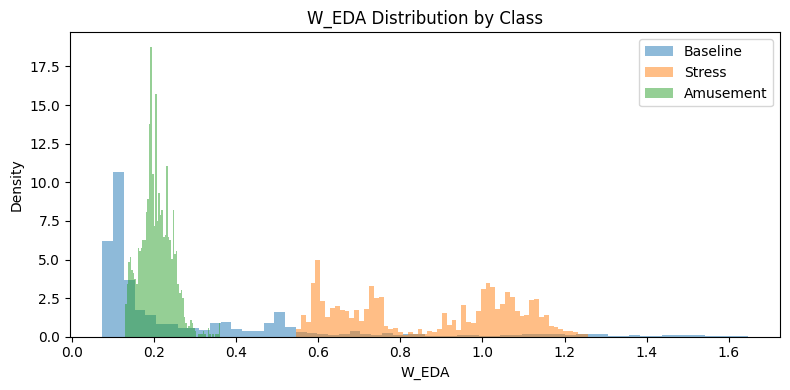

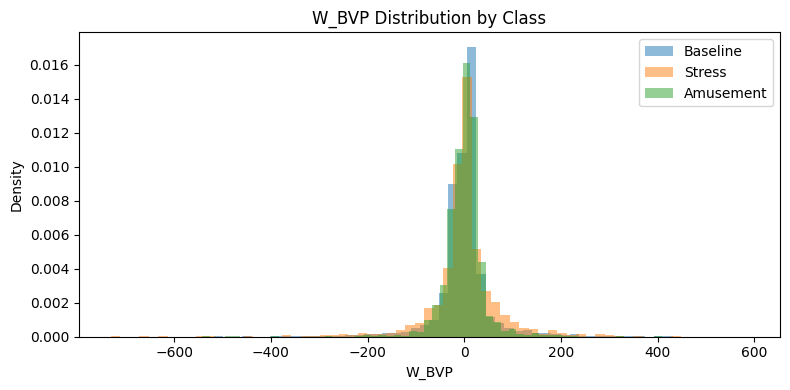

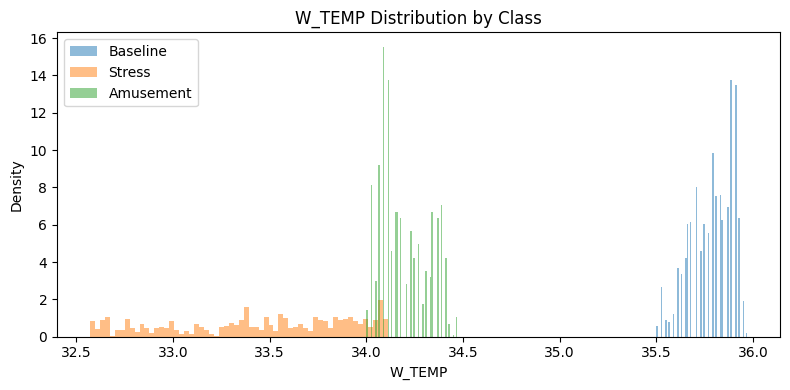

In [31]:
def hist_by_class(df, labels, col, bins=60):
    tmp = pd.concat([df[[col]], labels.rename("label")], axis=1).dropna()
    plt.figure(figsize=(8,4))
    for lv in [1,2,3]:
        vals = tmp[tmp["label"]==lv][col]
        if len(vals)>0:
            plt.hist(vals, bins=bins, alpha=0.5, density=True, label=LABEL_MAP[lv])
    plt.title(f"{col} Distribution by Class")
    plt.xlabel(col); plt.ylabel("Density")
    plt.legend(); plt.tight_layout(); plt.show()

for c in ["W_EDA","W_BVP","W_TEMP"]:
    if c in wrist_df_4hz.columns:
        hist_by_class(wrist_df_4hz, labels_4hz, c)

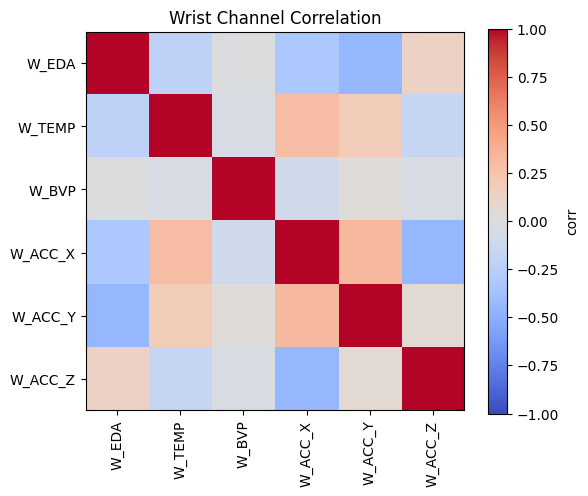

In [33]:
def correlation_heatmap(df, title="Correlation"):
    sample = df.dropna().iloc[::50]  # downsample for speed
    C = sample.corr()
    plt.figure(figsize=(6,5))
    plt.imshow(C, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar(label="corr")
    plt.xticks(range(len(C.columns)), C.columns, rotation=90)
    plt.yticks(range(len(C.index)), C.index)
    plt.title(title); plt.tight_layout(); plt.show()

corr_cols = [c for c in wrist_df_4hz.columns if c in ["W_EDA","W_BVP","W_TEMP","W_ACC_X","W_ACC_Y","W_ACC_Z"]]
if corr_cols:
    correlation_heatmap(wrist_df_4hz[corr_cols], "Wrist Channel Correlation")


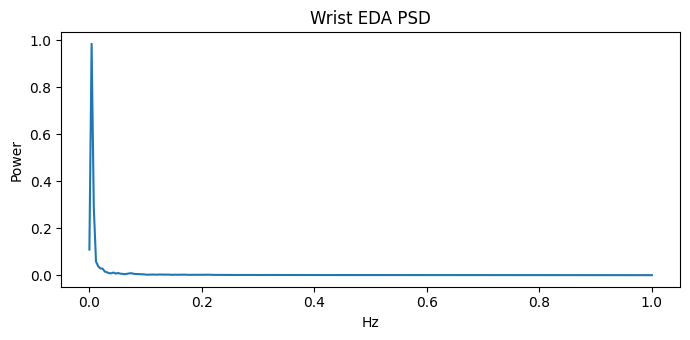

In [34]:
from scipy.signal import welch

def plot_psd(series, fs, max_hz=2.0, title="PSD"):
    x = series.dropna().astype(float).values
    f,Pxx = welch(x, fs=fs, nperseg=1024)
    m = f<=max_hz
    plt.figure(figsize=(7,3.5))
    plt.plot(f[m], Pxx[m])
    plt.title(title); plt.xlabel("Hz"); plt.ylabel("Power"); plt.tight_layout(); plt.show()

if "W_EDA" in wrist_df_4hz:
    plot_psd(wrist_df_4hz["W_EDA"], fs=4.0, max_hz=1.0, title="Wrist EDA PSD")

The wrist EDA signal has most of its power in very low frequencies (<0.2 Hz), which matches the slow nature of electrodermal activity. Above 0.2 Hz the power is near zero, showing little high-frequency content. This means low-pass filtering or downsampling can be applied without losing important information.”

&uarr; &uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;&uarr;

**ELI5 Summary of the above interpretation** <br>
The EDA signal changes very slowly, kind of like how your body temperature doesn’t jump around quickly. Almost all of its activity is at super-slow speeds, and there’s almost nothing happening fast. That’s why we can safely shrink the data (downsample) without losing anything important